None


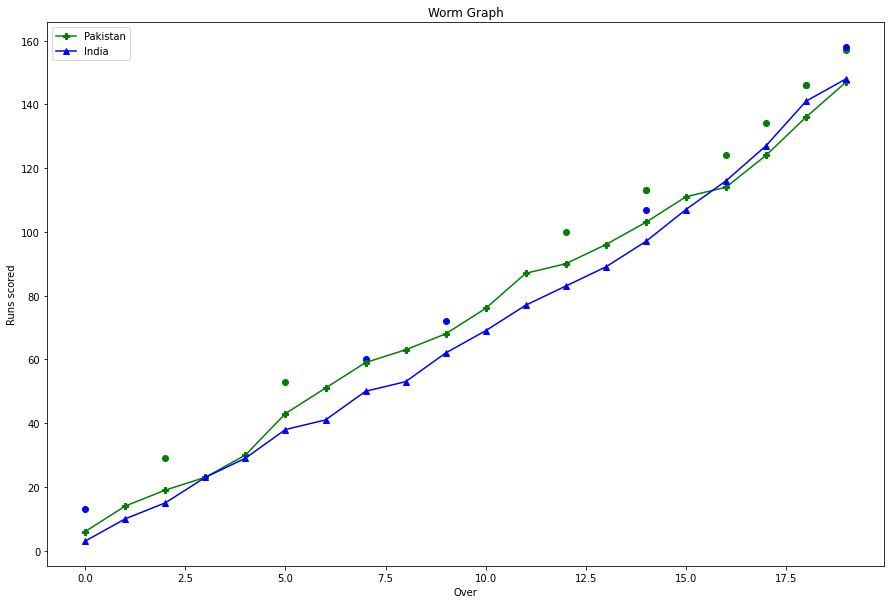

In [137]:
from lib2to3.pgen2.pgen import DFAState
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


def clean(df, type):
    df = df.dropna(how='all')
    df = df.reset_index()
    if type == 'bat':
        df = df.drop(columns=['Unnamed: 8', 'Unnamed: 9'])
        df = df.rename(columns={"Unnamed: 1": "Dismissal"})
    elif type == 'bowl':
        list1 = []
        for i in range(len(df)):
            if len(df.iloc[i]['BOWLING'].split(' ')) > 5:
                list1.append(i)
        for i in list1:
            df = df.drop(i)
    df = df.drop(columns=['index'])

    s = df.style.set_table_styles([
        {
            "selector": "thead",
            "props": [("background-color", "dodgerblue"), ("color", "white"),
                      ("border", "3px solid red"),
                      ]
        },
    ])

    return df 


class Series(object):
    def __init__(self, series_id=None, match_id=None):
        if series_id is not None and match_id is not None:
            self.series_id = series_id
            self.match_id = match_id
            self.url = f"https://www.espncricinfo.com/series/series-name-{series_id}/match-name-{match_id}/full-scorecard"
            self.page = requests.get(self.url)
            self.soup = BeautifulSoup(self.page.content, "html.parser")
            # self.match_id = str(self.soup.find_all(class_='ColumnistSmry')
            #                     [0]).split('.html')[0].split('/')[-1]

    def batting_df(self, bat_first):
        if bat_first:
            df = pd.read_html(self.url)[0]
        else:
            df = pd.read_html(self.url)[2]

        df = clean(df, 'bat')
        return df

    def bowling_df(self, bowl_first):
        if bowl_first:
            df = pd.read_html(self.url)[1]
        else:
            df = pd.read_html(self.url)[3]
        df = clean(df, 'bowl')
        return df

    def test_bat(self, bat_first, inning):
        if bat_first and inning == 1:
            df = pd.read_html(self.url)[0]
        elif bat_first and inning == 2:
            df = pd.read_html(self.url)[4]
        elif not bat_first and inning == 1:
            df = pd.read_html(self.url)[2]
        elif not bat_first and inning == 2:
            df = pd.read_html(self.url)[6]
        df = clean(df, 'bat')
        return df

    def test_bowl(self, bowl_first, inning):
        if bowl_first and inning == 1:
            df = pd.read_html(self.url)[1]
        if bowl_first and inning == 2:
            df = pd.read_html(self.url)[5]
        if not bowl_first and inning == 1:
            df = pd.read_html(self.url)[3]
        if not bowl_first and inning == 2:
            df = pd.read_html(self.url)[7]

        df = clean(df, 'bowl')
        return df

    def get_general_df_test(self):
        df = pd.read_html(self.url)[8]
        df = clean(df, 'none')
        return df

    def get_general_df(self):
        df = pd.read_html(self.url)[6]
        df = clean(df, 'none')
        return df

    def get_standings(self):
        df = pd.read_html(self.url)[8]
        df = clean(df, 'none')
        return df

    def test_df(self):
        df = pd.read_html(self.url)[6]
        return df

    def current_series(self):
        url = "https://www.espncricinfo.com/ci/content/match/fixtures_futures.html"
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        text_elements = []
        parsed_elements = []
        game_dict = {}
        header_list = []
        for element in soup.findAll("h2"):
            header_list.append(element.text)
        for element in soup.find("div", {"id": "first"}):
            text_elements.append(element.text.strip())
        for element in text_elements:
            if len(element) >= 1:
                parsed_elements.append(element.split("\n"))
        for element in parsed_elements:
            for subelement in element:
                if len(subelement) == 0:
                    element.remove(subelement)

        metadata = []
        for i in parsed_elements:
            list1 = []
            for a in i:
                if a in header_list:
                    pass
                else:
                    list1.append(a)
            game_dict[a] = list1
        data_tuples = list(zip(header_list, metadata))
        for i in data_tuples:
            print(i)
        return game_dict

    def get_series_by_year(self, year):
        url = f'https://www.espncricinfo.com/ci/engine/series/index.html?season={year};view=season'
        page = requests.get(url)
        soup = BeautifulSoup(page.content, 'html.parser')
        if format == 'test':
            text_elements = []
            for element in soup.find("section", {"class": "series-summary-wrap"}):
                text_elements.append(element.text.strip())
            text_elements
            print(text_elements)

    def get_results_by_year(self, year, format):
        url = f"https://stats.espncricinfo.com/ci/engine/records/team/match_results.html?class={format};id={year};type=year"
        df = pd.read_html(url)[0]
        return df

    def get_series_results(self, number):
        url = f"https://stats.espncricinfo.com/ci/content/records/{number}.html"
        df = pd.read_html(url)[0]
        return df

    def get_wagon_wheel(self):
        url = f"https://www.espncricinfo.com/series/series-name-{self.series_id}/match-name-{self.match_id}/match-statistics"
        self.page = requests.get(url)
        self.soup = BeautifulSoup(self.page.content, "html.parser")
        results = self.soup.find(id="__next")
        job_elements = results.find_all(
            "svg")

        print(job_elements)

    def get_bowler_analysis(self):
        url = f"https://www.espncricinfo.com/series/series-name-{self.series_id}/match-name-{self.match_id}/match-statistics"
        self.page = requests.get(url)
        self.soup = BeautifulSoup(self.page.content, "html.parser")
        results = self.soup.find(id="__next")
        job_elements = results.find_all(
            "table", class_="ds-w-full ds-table ds-table-sm ds-table-bordered ds-border-collapse ds-border ds-border-line ds-table-auto ds-text-tight-xs")
        print(job_elements)

    def manhattan(self):
        def wicket_graph(wicket_list, num):
            for i in range(len(wicket_list)):
                for j in range(wicket_list[i]):
                    if num == 1:
                        plt.scatter(i, (runs[::2][i]) + 1)
                    else:
                        plt.scatter(i+width, (runs[::2][i]) + 1)
        width = 0.3
        url = f"https://www.espncricinfo.com/series/series-name-{self.series_id}/match-name-{self.match_id}/match-overs-comparison"
        self.page = requests.get(url)
        self.soup = BeautifulSoup(self.page.content, "html.parser")
        results = self.soup.find(id="__next")
        job_elements = results.find_all(
            "span", class_="ds-text-tight-s ds-font-regular ds-ml-1")
        over_info = []
        for i in job_elements:
            over_info.append(i.text)
        runs = []
        wickets = []
        for i in over_info:
            runs.append(i[1:3].strip())
            wickets.append(i[9:11].strip())
        overs = len(runs)/2
        overs = int(overs)
        runs = [int(i) for i in runs]
        print(wickets)
        x = [int(i) for i in range(0,overs)]
        print(runs[::2])
        x2 = [int(i) for i in range(overs,overs*2)]
        print(runs[1::2])
        x_axis = np.arange(len(x))
        wickets = [int(i) for i in wickets]
        wickets1 = wickets[::2]
        wickets2 = wickets[1::2]
        plt.bar(x_axis, runs[::2], width=width, label = 'Team1')
        plt.bar(x_axis + width, runs[1::2], width=width, label = 'Team2')
        plt.xticks(x_axis + width/2, [i+1 for i in range(len(x))])
        plt.title('Manhattan Graph')
        plt.xlabel('Over')
        plt.ylabel('Runs scored')
        wicket_graph(wickets1, 1)
        wicket_graph(wickets2, 2)
        plt.legend()
    
    def worm(self):
    
        def wicket_graph(wicket_list, num):
            for i in range(len(wicket_list)):
                for j in range(wicket_list[i]):
                    if num == 1:
                        plt.scatter(i, (list1[i]) + 10, color='green')
                    else:
                        plt.scatter(i, (list2[i]) + 10,color='blue')
        width = 0.3
        url = f"https://www.espncricinfo.com/series/series-name-{self.series_id}/match-name-{self.match_id}/match-overs-comparison"
        self.page = requests.get(url)
        self.soup = BeautifulSoup(self.page.content, "html.parser")
        results = self.soup.find(id="__next")
        job_elements = results.find_all(
            "span", class_="ds-text-tight-s ds-font-regular ds-ml-1")
        over_info = []
        for i in job_elements:
            over_info.append(i.text)
        runs = []
        wickets = []
        for i in over_info:
            runs.append(i[1:3].strip())
            wickets.append(i[9:11].strip())
        runs = [int(i) for i in runs]
        team_1_bat = runs[::2]
        team_2_bat = runs[1::2]
        list1 = []
        list2 = []
        wickets = [int(i) for i in wickets]
        wickets1 = wickets[::2]
        wickets2 = wickets[1::2]
        for i in range(len(team_1_bat)):
            if i == 0:
                list1.append(team_1_bat[i])
                list2.append(team_2_bat[i])
            else:
                n = list1[i-1] + team_1_bat[i]
                j = list2[i-1] + team_2_bat[i]
                list1.append(n)
                list2.append(j)
        fig = plt.figure(figsize=(15, 10))
        plt.plot(np.arange(20),list1, 'g',marker='P', label = 'Pakistan')
        plt.plot(np.arange(20),list2, 'b', marker='^', label = 'India')
        plt.title('Worm Graph')
        plt.xlabel('Over')
        plt.ylabel('Runs scored')
        wicket_graph(wickets1, 1)
        wicket_graph(wickets2, 2)
        plt.legend()
        
        
        



print(Series(1327237, 1327270).worm())


NameError: name 'team_1_bat' is not defined